## MVP for GrowBikeNet implementation

### User Input:

In [1]:
from odc.geo.geom import multiline

city_name = 'Oelde'
seed_point_spacing = 1000 #distance between seed points
orig_crs = '4326'
proj_crs = '3857'
delta = 500 #maximal distance between seed point and actual point in OSM data

### Data from OSM

In [32]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import numpy as np
import momepy
from shapely.prepared import prep
from shapely.geometry import Point, LineString, MultiLineString
from scipy.spatial import cKDTree
import math
from itertools import combinations
from shapely.ops import unary_union
import networkx as nx

In [3]:
g = ox.graph_from_place(city_name, network_type='all')

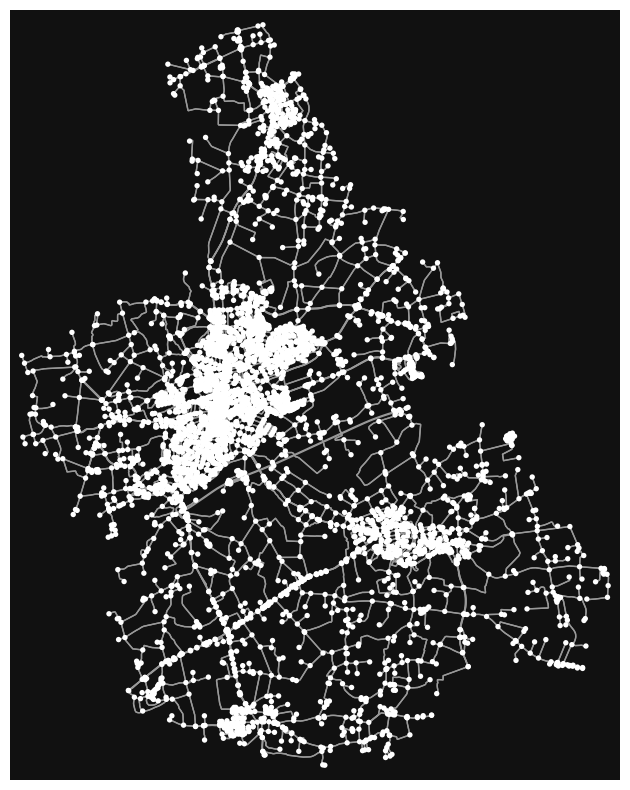

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [4]:
ox.plot_graph(g, figsize=(10, 10))

### Save Data

In [5]:
nodes, edges = momepy.nx_to_gdf(g, points=True, lines=True)

/var/folders/0t/3k3_vhb54dgb_d5kncl6k_x00000gn/T/ipykernel_72773/1992973538.py:1: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes, edges = momepy.nx_to_gdf(g, points=True, lines=True)


In [6]:
edges_gdf = gpd.GeoDataFrame(edges, crs=orig_crs)

In [7]:
edges_gdf

,osmid,highway,lanes,maxspeed,name,oneway,ref,reversed,length,junction,geometry,bridge,width,service,access,tunnel,node_start,node_end
0,1115969850,secondary,1,50,Keitlinghauser Straße,True,L 793,False,10.093885,NaN,None,NaN,NaN,NaN,NaN,NaN,0,4921
1,391936459,secondary,1,NaN,NaN,True,NaN,False,13.824712,roundabout,"LINESTRING (8.13178 51.80951, 8.13184 51.80952...",NaN,NaN,NaN,NaN,NaN,0,3
2,1115969849,secondary,1,50,In der Geist,True,L 793,False,11.136056,NaN,None,NaN,NaN,NaN,NaN,NaN,1,1542
3,391936459,secondary,1,NaN,NaN,True,NaN,False,14.343292,roundabout,"LINESTRING (8.13199 51.80969, 8.13198 51.80974...",NaN,NaN,NaN,NaN,NaN,1,3036
4,35815425,unclassified,NaN,NaN,Sudbergweg,False,NaN,True,6.244614,NaN,None,NaN,NaN,NaN,NaN,NaN,2,1545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14181,1460511115,service,NaN,NaN,NaN,False,NaN,True,70.002436,NaN,"LINESTRING (8.16371 51.82884, 8.16358 51.82882...",NaN,NaN,driveway,NaN,NaN,5437,5436
14182,33290693,unclassified,1,NaN,Ernstingweg,False,NaN,False,78.100740,NaN,None,NaN,NaN,NaN,NaN,NaN,5438,4022
14183,33290693,unclassified,1,NaN,Ernstingweg,False,NaN,True,275.450240,NaN,None,NaN,NaN,NaN,NaN,NaN,5438,1893
14184,683718160,residential,NaN,NaN,Willy-Brandt-Straße,False,NaN,True,4.240622,NaN,None,NaN,NaN,NaN,NaN,NaN,5439,1247


In [8]:
edges_gdf.to_crs(proj_crs, inplace=True)

In [9]:
nodes.to_crs(proj_crs, inplace=True)

In [10]:
nodes.to_file('nodes.gpkg', driver='GPKG')

In [11]:
edges_gdf.to_file('edges.gpkg', driver='GPKG')

### Convex Hull to create Polygon

In [12]:
hull = edges_gdf.union_all().convex_hull

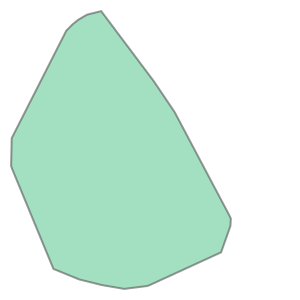

In [13]:
hull

### Generate evenly spaced seed points

In [14]:
latmin, lonmin, latmax, lonmax = hull.bounds

In [15]:
# https://stackoverflow.com/questions/66010964/fastest-way-to-produce-a-grid-of-points-that-fall-within-a-polygon-or-shape
prep_polygon = prep(hull)
points = []
for lat in np.arange(latmin, latmax, seed_point_spacing):
    for lon in np.arange(lonmin, lonmax, seed_point_spacing):
        points.append(Point((round(lat,4), round(lon,4))))

In [16]:
valid_points = []
valid_points.extend(filter(prep_polygon.contains, points))

In [17]:
points_df = pd.DataFrame(valid_points, columns=['Points'])

In [18]:
points_df

,Points
0,POINT (901026.2428 6765923.1417)
1,POINT (901026.2428 6766923.1417)
2,POINT (901026.2428 6767923.1417)
3,POINT (901026.2428 6768923.1417)
4,POINT (901026.2428 6769923.1417)
...,...
297,POINT (918026.2428 6764923.1417)
298,POINT (918026.2428 6765923.1417)
299,POINT (919026.2428 6761923.1417)
300,POINT (919026.2428 6762923.1417)


In [19]:
points_gdf = gpd.GeoDataFrame(points_df, crs=3857, geometry='Points')

In [20]:
points_gdf.to_crs(3857)

,Points
0,POINT (901026.243 6765923.142)
1,POINT (901026.243 6766923.142)
2,POINT (901026.243 6767923.142)
3,POINT (901026.243 6768923.142)
4,POINT (901026.243 6769923.142)
...,...
297,POINT (918026.243 6764923.142)
298,POINT (918026.243 6765923.142)
299,POINT (919026.243 6761923.142)
300,POINT (919026.243 6762923.142)


<Axes: >

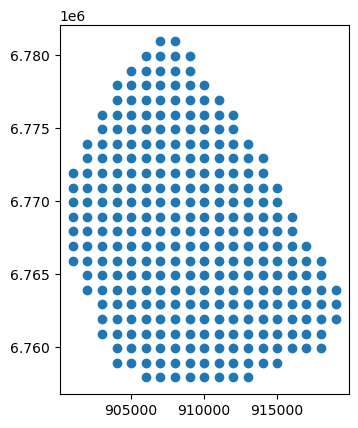

In [21]:
points_gdf.plot()

### Snap Seed points to OSM nodes

In [22]:
# https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas
nA = np.array(list(points_gdf.geometry.apply(lambda x: (x.x, x.y))))
nB = np.array(list(nodes.geometry.apply(lambda x: (x.x, x.y))))
btree = cKDTree(nB)
dist, idx = btree.query(nA, k=1)
gdB_nearest = nodes.iloc[idx].drop(columns="geometry").reset_index(drop=True)
gdf = pd.concat(
    [
        points_gdf.reset_index(drop=True),
        gdB_nearest,
        pd.Series(dist, name='dist')
    ],
    axis=1)

In [23]:
gdf_cleaned = gdf.drop(gdf[gdf.dist > delta].index)
gdf_cleaned

,Points,y,x,street_count,nodeID,highway,ref,dist
1,POINT (901026.243 6766923.142),51.816901,8.095518,4,442,NaN,NaN,230.346898
2,POINT (901026.243 6767923.142),51.820981,8.094855,4,962,NaN,NaN,135.334443
3,POINT (901026.243 6768923.142),51.826974,8.094031,1,1931,NaN,NaN,22.941959
4,POINT (901026.243 6769923.142),51.831652,8.096989,1,3212,NaN,NaN,372.819309
5,POINT (901026.243 6770923.142),51.837113,8.092713,1,4524,NaN,NaN,246.894727
...,...,...,...,...,...,...,...,...
296,POINT (918026.243 6763923.142),51.798508,8.247702,1,4960,NaN,NaN,181.001635
297,POINT (918026.243 6764923.142),51.804452,8.248334,3,1493,NaN,NaN,190.880517
299,POINT (919026.243 6761923.142),51.787468,8.252937,3,2031,NaN,NaN,341.445630
300,POINT (919026.243 6762923.142),51.794261,8.256002,1,5143,NaN,NaN,91.491374


In [24]:
snapped_points = nodes.loc[nodes['nodeID'].isin(gdf_cleaned['nodeID'])]

In [26]:
snapped_points.drop(columns=['y', 'x','street_count', 'highway', 'ref'], inplace=True)

/var/folders/0t/3k3_vhb54dgb_d5kncl6k_x00000gn/T/ipykernel_72773/1855639553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapped_points.drop(columns=['y', 'x','street_count', 'highway', 'ref'], inplace=True)


In [33]:
snapped_points

,nodeID,geometry
129,129,POINT (914844.325 6763930.873)
171,171,POINT (910992.526 6762096.844)
174,174,POINT (909998.076 6760645.723)
176,176,POINT (912159.377 6761136.275)
178,178,POINT (913014.856 6762091.535)
...,...,...
5174,5174,POINT (915095.395 6766849.549)
5317,5317,POINT (909234.791 6763846.163)
5341,5341,POINT (914894.953 6765851.651)
5417,5417,POINT (918083.956 6761862.513)


<Axes: >

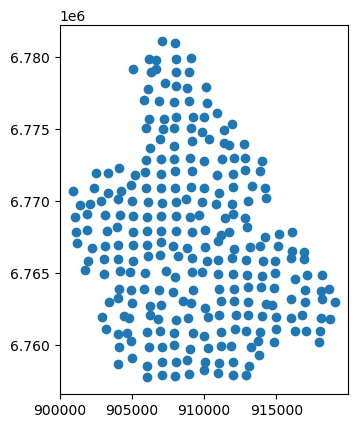

In [27]:
snapped_points.plot()

### Greedy triangulation

In [28]:
pairs = []
edges = []
distances = []

for pair in combinations(snapped_points["nodeID"], 2):

    edge = LineString(snapped_points.loc[list(pair)].geometry)

    pairs.append(pair)
    edges.append(edge)
    distances.append(edge.length)

df = pd.DataFrame(
    {
        "pair": pairs,
        "e": edges,
        "dist": distances
    }
)

df = df.sort_values(by="dist", ascending=True).reset_index(drop=True)
df = df[df["dist"]>0].reset_index(drop=True) # only keep distances > 0
df.tail(10)

,pair,e,dist
35235,"(4028, 4561)",LINESTRING (907037.1554444014 6781067.22749632...,23244.639451
35236,"(2576, 5065)",LINESTRING (906062.3640593719 6757758.16488605...,23253.100998
35237,"(2576, 4028)",LINESTRING (906062.3640593719 6757758.16488605...,23329.436727
35238,"(2756, 4028)",LINESTRING (913134.3577260795 6758529.80940448...,23347.614223
35239,"(2388, 5065)",LINESTRING (911966.6051357092 6757933.82817607...,23351.443404
35240,"(2723, 4028)",LINESTRING (910981.9397118464 6758042.50892374...,23360.200947
35241,"(216, 4028)",LINESTRING (917953.2337671823 6760234.67382140...,23519.269941
35242,"(181, 5065)",LINESTRING (912884.7794277212 6757929.00754767...,23531.895224
35243,"(2388, 4028)",LINESTRING (911966.6051357092 6757933.82817607...,23652.772319
35244,"(181, 4028)",LINESTRING (912884.7794277212 6757929.00754767...,23865.706121


In [29]:
# helper function
def intersects_properly(geom1, geom2):
    '''
    for 2 shapely geometries, check whether they "properly intersect" (i.e. intersect but not touch, i.e. don't share endpoints)
    '''
    return geom1.intersects(geom2) and not geom1.touches(geom2)

In [46]:
# this should work, is suuuper slow tho (keyboard interrupt after 23 minutes)
# number of edges needs to be reduced

current_edges = MultiLineString()
edge_list = []

# go through all node pair combinations, if they dont intersect with existing edges add to multilinestring
for _, row in df.iterrows():
    new_edge = row.e
    pair = row.pair
    if not intersects_properly(current_edges, new_edge):
        current_edges = MultiLineString([linestring for linestring in current_edges.geoms] + [new_edge])
        edge_list.append(pair)

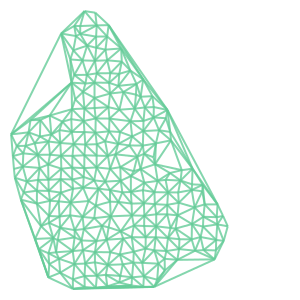

In [47]:
current_edges

In [53]:
A = nx.Graph()
A.add_nodes_from(snapped_points.index)
A.add_edges_from(edge_list)

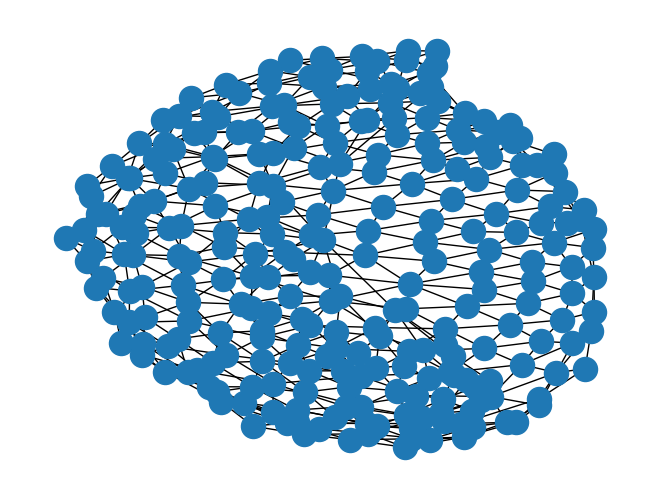

In [54]:
nx.draw(A)

### Add edge attribute betweenness to A

In [57]:
bc_values = nx.edge_betweenness_centrality(A, normalized=True)

In [58]:
nx.set_edge_attributes(A, bc_values, name='betweenness_centrality')

### Add edge attribute closeness to A